<a href="https://colab.research.google.com/github/Nishchal860156/Streamlined_Judiciary_Data/blob/main/SIH_internal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
ls

gdrive/  sample_data/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px

In [ ]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
court = pd.read_csv('NDAP_REPORT_7150.csv')

In [ ]:
print(court)

In [ ]:
court.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2067 entries, 0 to 2066
Data columns (total 29 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Rowid                                                     2067 non-null   int64  
 1   Country                                                   2067 non-null   object 
 2   State lgd code                                            2067 non-null   int64  
 3   State                                                     2067 non-null   object 
 4   District lgd code                                         2067 non-null   int64  
 5   District                                                  2067 non-null   object 
 6   Year                                                      2067 non-null   int64  
 7   District and taluk court case type                        2067 non-null   object 
 8   Pending cases for 

In [ ]:
court.groupby('District and taluk court case type')['Pending cases'].agg('sum')/10000000

District and taluk court case type
Civil       1.069470
Criminal    2.944736
Total       4.014207
Name: Pending cases, dtype: float64

In [ ]:
court_short = court[court['District and taluk court case type']!='Total']
court_short = court_short.rename(columns={'District and taluk court case type':'Case_type'})
court_short['pending_lakh'] = court_short['Pending cases']/100000

In [ ]:
case_type = court_short.groupby('Case_type')['pending_lakh'].agg('sum').reset_index()

dat1 = go.Pie(values=case_type.pending_lakh,labels=case_type.Case_type)
lay1 = go.Layout(title='Break-up of case type in lakhs',height=500,width=500)
fig1 = go.Figure(dat1,lay1)
py.iplot(fig1,filename='casetype')

In [ ]:
court_short['pending_over_5_yrs'] = court_short['Pending cases for a period of 5 to 10 years']+court_short['Pending cases for a period of 10 to 20 years']+court_short['Pending cases for a period of 20 to 30 years']+court_short['Pending cases over 30 years']
court_short['pending_over_5_yrs_lakh'] = court_short['pending_over_5_yrs']/100000

In [ ]:
states_pending_total = court_short.groupby('State')['pending_lakh'].agg('sum').reset_index()
states_5yrs_total = court_short.groupby('State')['pending_over_5_yrs_lakh'].agg('sum').reset_index()
states_5yrs_comb = pd.merge(states_pending_total,states_5yrs_total,on='State')
states_5yrs_comb['perc_over_5yrs'] = states_5yrs_comb['pending_over_5_yrs_lakh']/states_5yrs_comb['pending_lakh']*100
states_5yrs_comb1 = states_5yrs_comb.groupby('State')['perc_over_5yrs'].agg('mean').sort_values(ascending=False).reset_index()

In [ ]:
dat2 = go.Bar(x=states_5yrs_comb1.State,y=states_5yrs_comb1.perc_over_5yrs,)
lay2 = go.Layout(title='States with highest % of cases pending for >5 years',height=600,width=1200)
fig2 = go.Figure(dat2,lay2)
py.iplot(fig2,filename='5yrs')

In [ ]:
state_case_type = court_short.groupby(['State','Case_type'])['pending_lakh'].agg('sum').reset_index()

state_case_type.head(5)

,State,Case_type,pending_lakh
0,Andaman And Nicobar Islands,Civil,0.00000
1,Andaman And Nicobar Islands,Criminal,0.00000
2,Andhra Pradesh,Civil,4.10998
3,Andhra Pradesh,Criminal,3.46059
4,Assam,Civil,0.84700


In [ ]:
state_wise_case_pivot = pd.pivot_table(data=state_case_type,values='pending_lakh',index='State',columns='Case_type').reset_index()

state_wise_case_pivot['criminal_pcnt'] = (state_wise_case_pivot['Criminal']/(state_wise_case_pivot['Civil']+state_wise_case_pivot['Criminal']))*100
state_wise_case_pivot['civil_pcnt'] = 100-state_wise_case_pivot['criminal_pcnt']
state_wise_case_pivot1 = state_wise_case_pivot.groupby('State')['criminal_pcnt'].agg('mean').sort_values(ascending=False).reset_index()

In [ ]:
dat3 = go.Bar(x=state_wise_case_pivot1.State,y=state_wise_case_pivot1.criminal_pcnt)
lay3 = go.Layout(title='States with highest % of criminal cases',height=600,width=1200)
fig3 = go.Figure(dat3,lay3)
py.iplot(fig3,filename='criminal')

In [ ]:
state_comb2 = pd.merge(states_5yrs_comb1,state_wise_case_pivot1,on='State')
state_comb2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34 entries, 0 to 33
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           34 non-null     object 
 1   perc_over_5yrs  33 non-null     float64
 2   criminal_pcnt   33 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.1+ KB


<Axes: xlabel='perc_over_5yrs', ylabel='criminal_pcnt'>

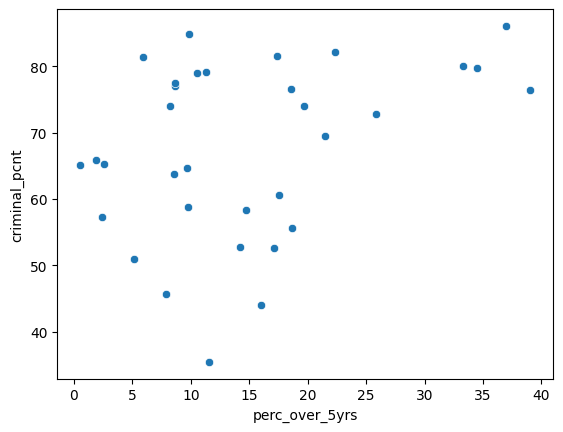

In [ ]:
sns.scatterplot(x=state_comb2.perc_over_5yrs,y=state_comb2.criminal_pcnt)

In [ ]:
pend_evidence = court_short.groupby('Case_type')['Cases pending at evidence or argument or judgement stage'].agg('sum').reset_index()
pending_compliance = court_short.groupby('Case_type')['Cases pending at compliance or steps or stay stage'].agg('sum').reset_index()
pending_appearance = court_short.groupby('Case_type')['Cases pending at appearance or service-related stage'].agg('sum').reset_index()
pending_charge = court_short.groupby('Case_type')['Cases pending at pleadings or issues or charge stage'].agg('sum').reset_index()

In [ ]:
pend_1 = pd.merge(pend_evidence,pending_compliance,on='Case_type')
pend_2 = pd.merge(pending_appearance,pending_charge,on='Case_type')
pend_3 = pd.merge(pend_1,pend_2,on='Case_type')

In [ ]:
pend_3

,Case_type,Cases pending at evidence or argument or judgement stage,Cases pending at compliance or steps or stay stage,Cases pending at appearance or service-related stage,Cases pending at pleadings or issues or charge stage
0,Civil,4205686.0,1847710.0,2706021.0,1453075.0
1,Criminal,9193665.0,2067870.0,13440245.0,3072056.0


In [ ]:
pend_pivot = pend_3.transpose()
pend_pivot = pend_pivot.drop("Case_type")
pend_pivot = pend_pivot.rename(columns={0:'Civil',1:'Criminal','index':'pending_type'})

In [ ]:
pend_pivot

,Civil,Criminal
Cases pending at evidence or argument or judgement stage,4205686.0,9193665.0
Cases pending at compliance or steps or stay stage,1847710.0,2067870.0
Cases pending at appearance or service-related stage,2706021.0,13440245.0
Cases pending at pleadings or issues or charge stage,1453075.0,3072056.0


In [ ]:
pend_pivot.index

Index(['Cases pending at evidence or argument or judgement stage',
       'Cases pending at compliance or steps or stay stage',
       'Cases pending at appearance or service-related stage',
       'Cases pending at pleadings or issues or charge stage'],
      dtype='object')

In [ ]:
fig = px.bar(pend_pivot,x=pend_pivot.index,y='Civil',title='Pendency reasons for Civil cases_million')
fig.show()

fig1 = px.bar(pend_pivot,x=pend_pivot.index,y='Criminal',title='Pendency reasons for criminal cases_million')
fig1.show()